# Uber Trip Time Series Analysis

### Authors:

Suman Senapati

Koelgeet Kaur

Dr. Sanjay Kumar

### Based on the dataset (source: https://github.com/fivethirtyeight/uber-tlc-foil-response) we are working on, we may look at the following goals/objectives:

## **1. Ride Demand Prediction**
### **Goal:** Predict the number of Uber pickups at a given time and location.
- **Input Features:**  
  - Date & Time (hour, day, month, weekday/weekend)
  - Location (Latitude & Longitude or Zone ID)
- **Output:** Expected number of Uber pickups.
- **Models:**  
  - **Time Series Models:** ARIMA, SARIMA, Facebook Prophet  
  - **Machine Learning Models:** XGBoost, Random Forest, LSTM (Deep Learning)

**Use Case:** Helps Uber optimize driver deployment and dynamic pricing.


## **2. Trip Hotspot Prediction**
### **Goal:** Predict the most popular pickup locations at different times of the day.
- **Input Features:**  
  - Time of Day, Day of Week
  - Past demand in the same location
- **Output:** Top **N** locations where demand will be high.
- **Models:**  
  - **Clustering:** K-Means, DBSCAN (to identify ride hotspots)
  - **Classification Model:** Random Forest
  - **Time series:** LSTM

**Use Case:** Uber can allocate more drivers in high-demand areas.


## **3. Peak Hour Traffic Analysis**
### **Goal:** Predict when ride demand will surge based on past trends.
- **Input Features:**  
  - Hourly Uber pickup trends
  - Day of the week, Holiday indicators
  - External data (weather, events)
- **Output:** Predict peak ride demand hours.
- **Models:**  
  - Time Series Forecasting (LSTM, ARIMA, Prophet)
  - Classification (Random Forest, XGBoost)

**Use Case:** Helps Uber optimize surge pricing and driver incentives.

---


## 0. Library Installation (If Any)

In [1]:
pip install folium geopandas contextily geoplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 60.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import folium
from folium.plugins import HeatMap
import geopandas
import kagglehub
from kagglehub import KaggleDatasetAdapter
import geoplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import joblib
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 2. Importing datasets

The dataset we are working on has separate files on uber rides data, with various dates. We shall target to use data from these files and use the sets which have complete information.

#### Dataset 1: Pickup date and base number

In [3]:
pickup_df = pd.read_csv("/kaggle/input/uber-trip-data-jan-june-2015/uber-raw-data-janjune-15.csv")

#### Dataset 2: Number of Trip, Active vehicles and base 

In [4]:
trip_veh_df = pd.read_csv("/kaggle/input/uber-trip-data-jan-and-feb-2015/Uber-Jan-Feb-FOIL.csv")

#### Dataset 3: 

In [5]:
csv_files = glob.glob("/kaggle/input/uber-raw-data-apr-2014-sep-2014/*.csv")
dfs = [pd.read_csv(file) for file in csv_files]
lat_long_df = pd.concat(dfs, ignore_index=True)

## 3. Data Pre-processing

In [6]:
pickup_df.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [7]:
trip_veh_df.head()

,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [8]:
lat_long_df.head()

,Date/Time,Lat,Lon,Base
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512
3,5/1/2014 0:17:00,40.7463,-74.0011,B02512
4,5/1/2014 0:17:00,40.7594,-73.9734,B02512


So, now we have three dataframes consisting of the data from different input files. We need to sensibly merge them before proceeding

In [9]:
pickup_df.shape

(14270479, 4)

In [10]:
trip_veh_df.shape

(354, 4)

In [11]:
lat_long_df.shape

(4534327, 4)

As can be seen from the dataframe shapes that the vehicle and trip data is pretty scarce. Let's explore the range of dates which is covered in these

In [12]:
pickup_df["DateTime"] = pd.to_datetime(pickup_df["Pickup_date"])
trip_veh_df["DateTime"] = pd.to_datetime(trip_veh_df["date"])
lat_long_df["DateTime"] = pd.to_datetime(lat_long_df["Date/Time"])

In [13]:
pickup_df.dtypes

Dispatching_base_num            object
Pickup_date                     object
Affiliated_base_num             object
locationID                       int64
DateTime                datetime64[ns]
dtype: object

In [14]:
trip_veh_df.dtypes

dispatching_base_number            object
date                               object
active_vehicles                     int64
trips                               int64
DateTime                   datetime64[ns]
dtype: object

In [15]:
lat_long_df.dtypes

Date/Time            object
Lat                 float64
Lon                 float64
Base                 object
DateTime     datetime64[ns]
dtype: object

In [16]:
base_mapping = {
    "B02512": "Unter",
    "B02598": "Hinter",
    "B02617": "Weiter",
    "B02682": "Schmecken",
    "B02764": "Danach-NY",
    "B02765": "Grun",
    "B02835": "Dreist",
    "B02836": "Drinnen"
}

In [17]:
pickup_df['Base Name'] = pickup_df['Dispatching_base_num'].map(base_mapping)
trip_veh_df['Base Name'] = trip_veh_df['dispatching_base_number'].map(base_mapping)
lat_long_df['Base Name'] = lat_long_df['Base'].map(base_mapping)

The oldest and newest entries in the dataframes are checked to understand how the dataframes can be merged or used together

In [18]:
print(f"Oldest date in dataframe 1 is {pickup_df['DateTime'].min()} and newest date is {pickup_df['DateTime'].max()}")
print(f"Oldest date in dataframe 2 is {trip_veh_df['DateTime'].min()} and newest date is {trip_veh_df['DateTime'].max()}")
print(f"Oldest date in dataframe 3 is {lat_long_df['DateTime'].min()} and newest date is {lat_long_df['DateTime'].max()}")

Oldest date in dataframe 1 is 2015-01-01 00:00:05 and newest date is 2015-06-30 23:59:00
Oldest date in dataframe 2 is 2015-01-01 00:00:00 and newest date is 2015-02-28 00:00:00
Oldest date in dataframe 3 is 2014-04-01 00:00:00 and newest date is 2014-09-30 22:59:00


Dataframe 3 cannot be used alongside the other two dataframes. In this notebook, we will explore the trip hotspots using dataset 3, and try to predict the top hotspots based on date and time

In [19]:
print(lat_long_df.head(5))

          Date/Time      Lat      Lon    Base            DateTime Base Name
0  5/1/2014 0:02:00  40.7521 -73.9914  B02512 2014-05-01 00:02:00     Unter
1  5/1/2014 0:06:00  40.6965 -73.9715  B02512 2014-05-01 00:06:00     Unter
2  5/1/2014 0:15:00  40.7464 -73.9838  B02512 2014-05-01 00:15:00     Unter
3  5/1/2014 0:17:00  40.7463 -74.0011  B02512 2014-05-01 00:17:00     Unter
4  5/1/2014 0:17:00  40.7594 -73.9734  B02512 2014-05-01 00:17:00     Unter


For simplicity, we will copy the lat_long_df to a new dataframe named 'df'

In [20]:
df = lat_long_df.copy(deep=True)

In [21]:
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

In [22]:
df.isna().sum().sum()

0

In [23]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  object        
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
 4   DateTime   datetime64[ns]
 5   Base Name  object        
 6   Year       int32         
 7   Month      int32         
 8   Day        int32         
 9   Hour       int32         
 10  Minute     int32         
 11  DayOfWeek  int32         
dtypes: datetime64[ns](1), float64(2), int32(6), object(3)
memory usage: 311.3+ MB
None
                Lat           Lon                       DateTime       Year  \
count  4.534327e+06  4.534327e+06                        4534327  4534327.0   
mean   4.073926e+01 -7.397302e+01  2014-07-11 18:50:50.578151936     2014.0   
min    3.965690e+01 -7.492900e+01            2014-04-01 00:00:00     2014.0   
25%    4.072110e+01 -7.399650e+01            2014

## 4. Exploratory Data Analysis

### 4.1 Univariate Analysis

#### Distribution of Pickups Over Time

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


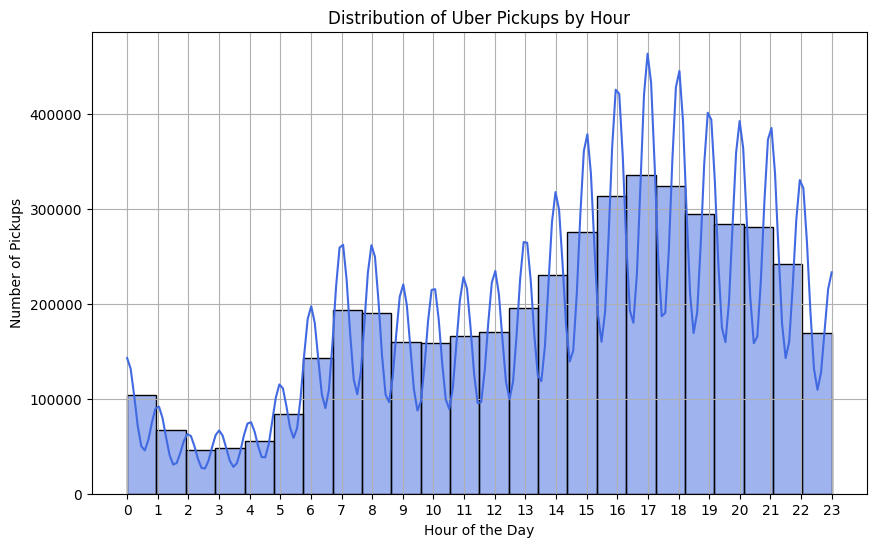

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'], bins=24, kde=True, color="royalblue")
plt.title("Distribution of Uber Pickups by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(24))
plt.grid()
plt.show()

 #### Distribution of Pickups by Day of the Week

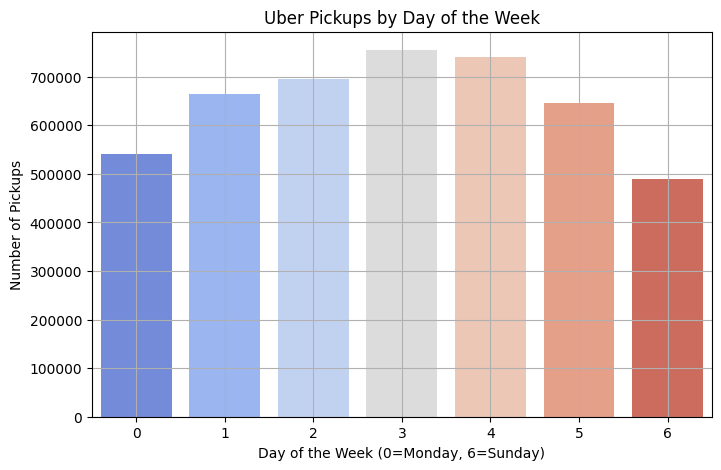

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["DayOfWeek"], palette="coolwarm")
plt.title("Uber Pickups by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Pickups")
plt.grid()
plt.show()

#### Base Distribution

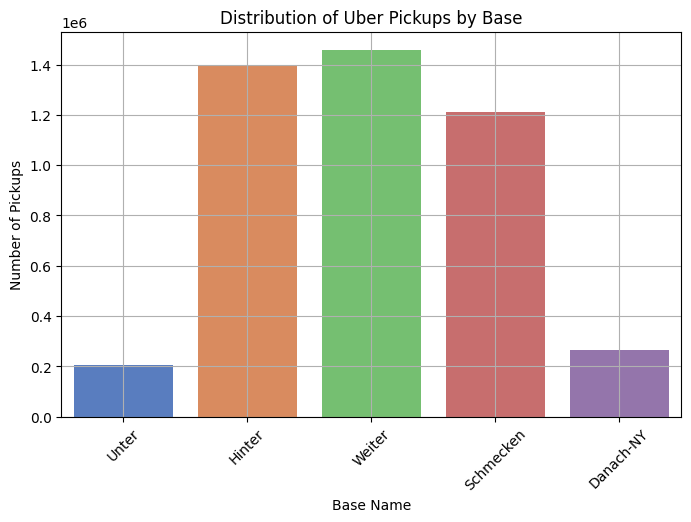

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Base Name"], palette="muted")
plt.title("Distribution of Uber Pickups by Base")
plt.xlabel("Base Name")
plt.ylabel("Number of Pickups")
plt.xticks(rotation=45)
plt.grid()
plt.show()

#### Geographic Distribution of Pickups

#### Using Scatterplot

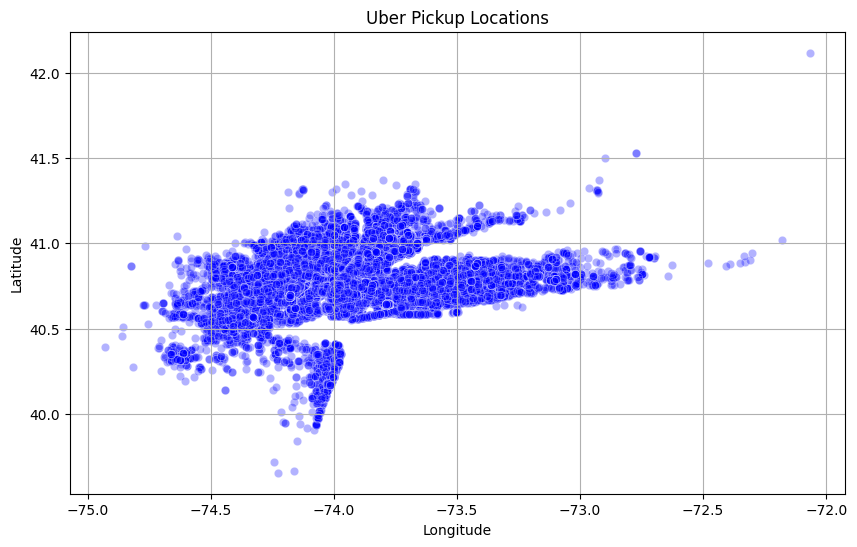

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Lon"], y=df["Lat"], alpha=0.3, color='blue')
plt.title("Uber Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

#### Using Maps

NYC Shapefile CRS: EPSG:2263


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


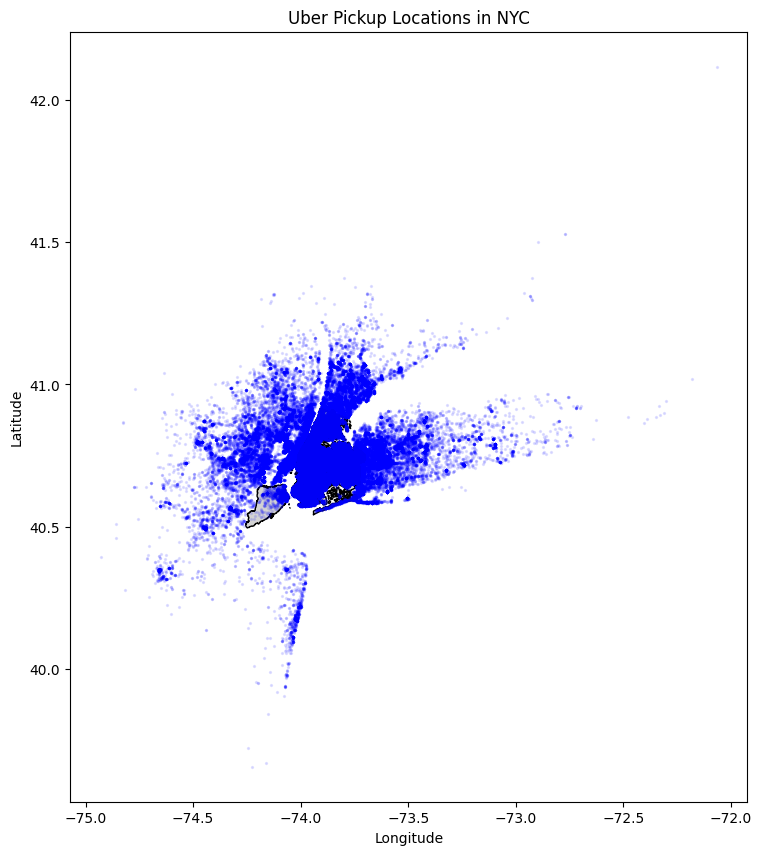

In [28]:
nyc_map = geopandas.read_file("/kaggle/input/nyc-borough-boundaries/nybb.shp")

print("NYC Shapefile CRS:", nyc_map.crs)

crs={'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

gdf=geopandas.GeoDataFrame(df,crs=crs,geometry=geopandas.points_from_xy(df["Lon"], df["Lat"]))



fig, ax = plt.subplots(figsize=(10, 10))
boroughs.plot(ax=ax, color="lightgrey", edgecolor="black")
gdf.plot(ax=ax, markersize=2, color="blue", alpha=0.1)

plt.title("Uber Pickup Locations in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 4.2 Multivariate Analysis

### 4.2.1 Pair Plot

In [29]:
print(df["Base Name"])

0              Unter
1              Unter
2              Unter
3              Unter
4              Unter
             ...    
4534322    Danach-NY
4534323    Danach-NY
4534324    Danach-NY
4534325    Danach-NY
4534326    Danach-NY
Name: Base Name, Length: 4534327, dtype: object


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

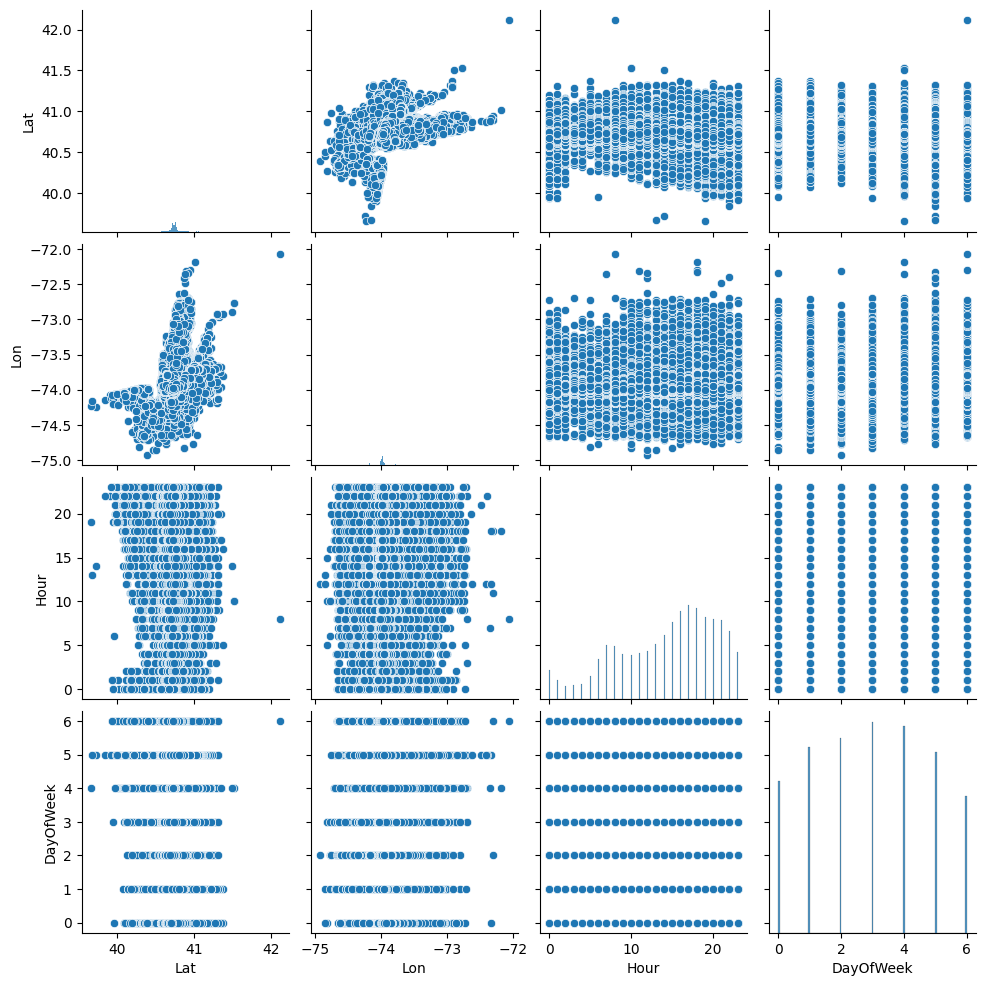

In [30]:
sns.pairplot(df[['Lat', 'Lon', 'Hour', 'DayOfWeek']])
plt.show()

<ipython-input-31-fdbe3ad87e47>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = df.resample('H', on='DateTime').size()


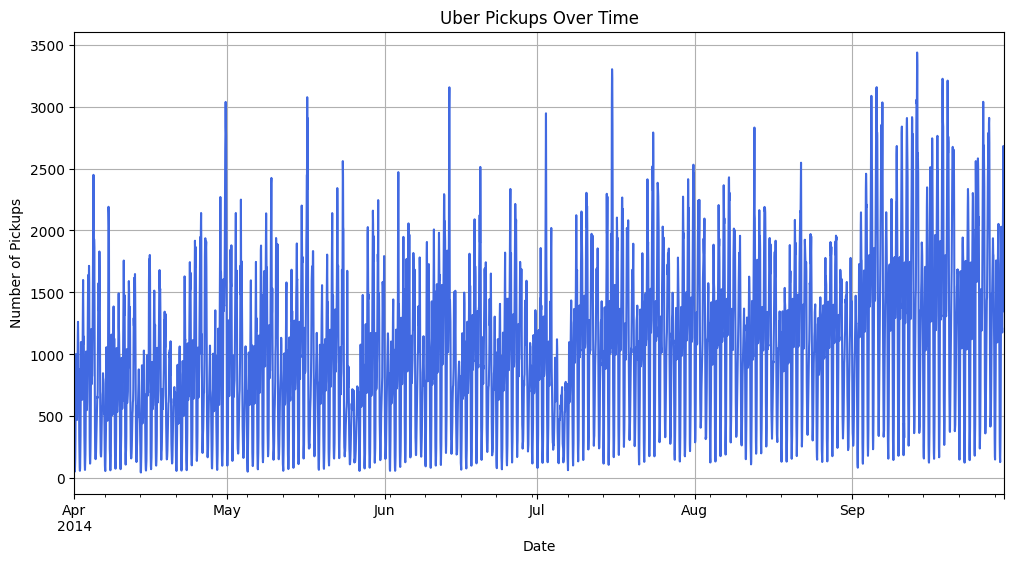

In [31]:
time_series = df.resample('H', on='DateTime').size()

# Plot the time series
plt.figure(figsize=(12, 6))
time_series.plot(title="Uber Pickups Over Time", color="royalblue")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.grid()
plt.show()

In [32]:
result = adfuller(time_series)
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is NOT stationary. Differencing needed.")

ADF Statistic: -4.906252894492546
P-Value: 3.391006185776848e-05
The time series is stationary.


## 5. Time Series Modelling

### Prelim steps

<ipython-input-33-caa9d0854bbb>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time_series = df.resample("H", on="DateTime").size().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


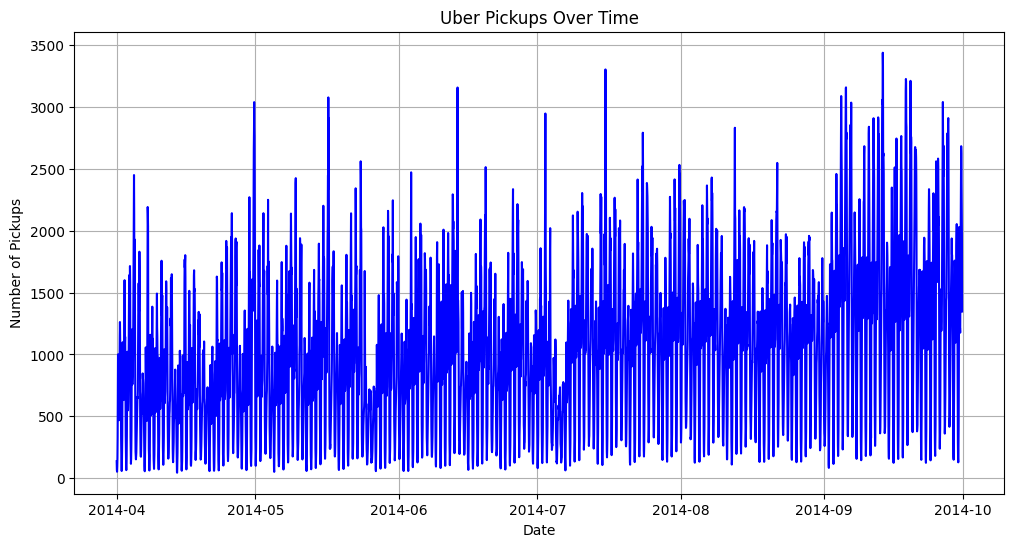

In [33]:
df_time_series = df.resample("H", on="DateTime").size().reset_index()
df_time_series.columns = ["DateTime", "Pickups"]

# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_time_series["DateTime"], y=df_time_series["Pickups"], color="blue")
plt.title("Uber Pickups Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.grid()
plt.show()

In [34]:
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series["Pickups"][:train_size], df_time_series["Pickups"][train_size:]

In [35]:
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%\n")

### 5.1 Moving Average Baseline model

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

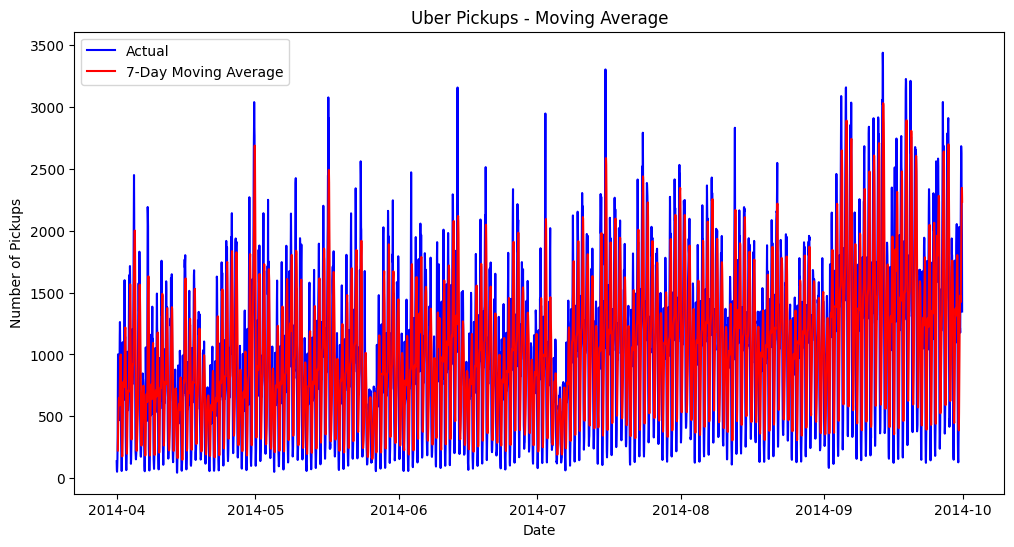

In [36]:
df_time_series["MA_7"] = df_time_series["Pickups"].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_time_series["DateTime"], y=df_time_series["Pickups"], label="Actual", color="blue")
sns.lineplot(x=df_time_series["DateTime"], y=df_time_series["MA_7"], label="7-Day Moving Average", color="red")
plt.title("Uber Pickups - Moving Average")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.legend()
plt.show()

### 5.2 Forecasting with ARIMA

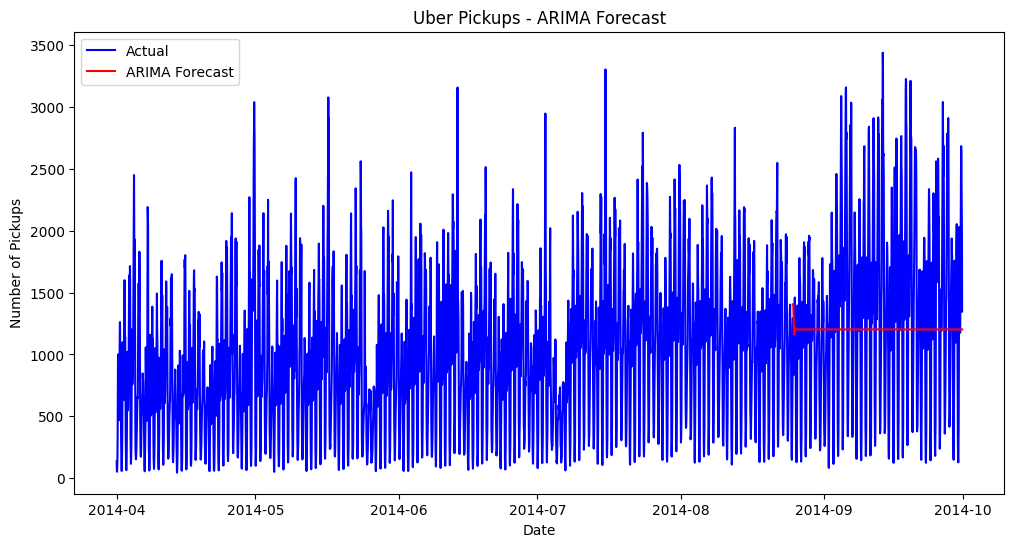

In [37]:
arima_m = ARIMA(train, order=(5,1,0))
model_fit = arima_m.fit()

forecast = model_fit.forecast(steps=len(test))

forecast_index = df_time_series["DateTime"][train_size:train_size + len(forecast)]

plt.figure(figsize=(12, 6))
plt.plot(df_time_series["DateTime"], df_time_series["Pickups"], label="Actual", color="blue")
plt.plot(forecast_index, forecast, label="ARIMA Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.title("Uber Pickups - ARIMA Forecast")
plt.legend()
plt.show()

In [38]:
evaluate_forecast(test, forecast, "ARIMA")

ARIMA Evaluation:
MAE: 623.88
MSE: 597843.26
RMSE: 773.20
MAPE: 91.84%



### 5.2 Forecasting with SARIMA

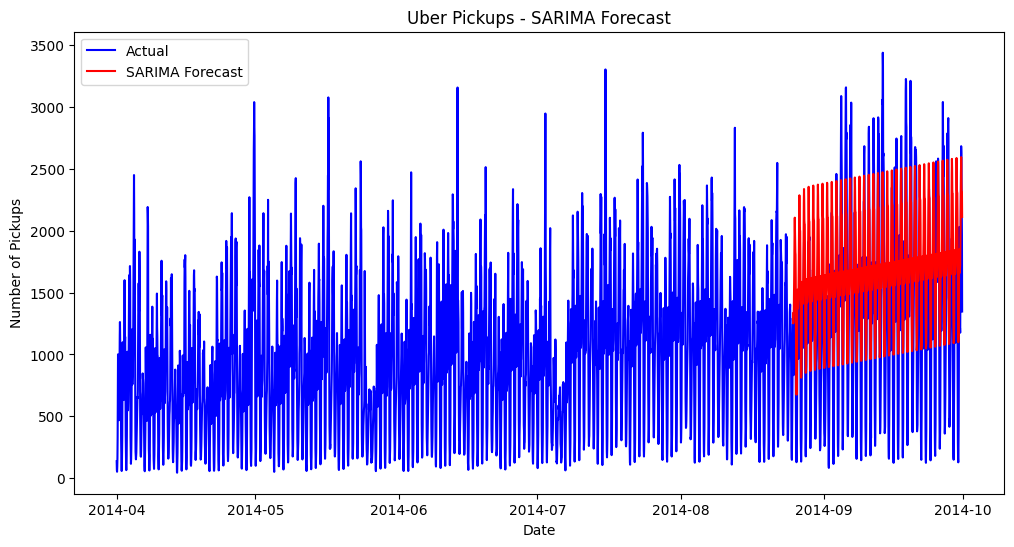

In [39]:
sarima_m = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_fit = sarima_m.fit()

forecast = sarima_fit.get_forecast(steps=len(test)).predicted_mean

forecast_index = df_time_series["DateTime"][train_size:train_size + len(forecast)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_time_series["DateTime"], df_time_series["Pickups"], label="Actual", color="blue")
plt.plot(forecast_index, forecast, label="SARIMA Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.title("Uber Pickups - SARIMA Forecast")
plt.legend()
plt.show()

In [40]:
evaluate_forecast(test, forecast, "SARIMA")

SARIMA Evaluation:
MAE: 474.58
MSE: 312986.74
RMSE: 559.45
MAPE: 81.67%



### 5.4 Forecasting with XGBoost

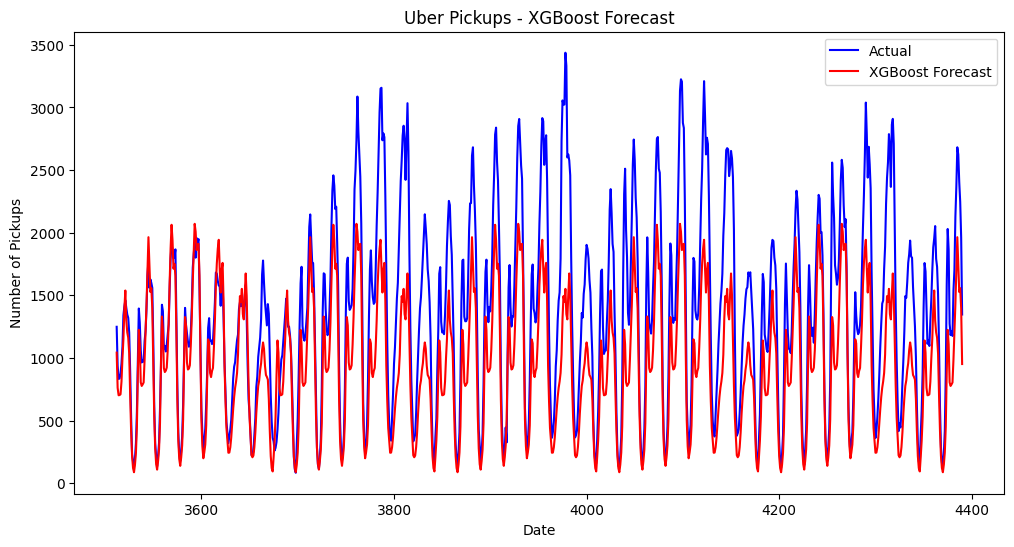

In [41]:
df_time_series["Hour"] = df_time_series["DateTime"].dt.hour
df_time_series["DayOfWeek"] = df_time_series["DateTime"].dt.dayofweek

X = df_time_series[["Hour", "DayOfWeek"]]
y = df_time_series["Pickups"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="XGBoost Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Number of Pickups")
plt.title("Uber Pickups - XGBoost Forecast")
plt.legend()
plt.show()

In [42]:
evaluate_forecast(y_test, y_pred, "XGBoost")

XGBoost Evaluation:
MAE: 429.28
MSE: 296126.57
RMSE: 544.18
MAPE: 30.76%



### 5.3 Forecasting with LSTM

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0352 - val_loss: 0.0189
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0098 - val_loss: 0.0121
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0059 - val_loss: 0.0068
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/ste

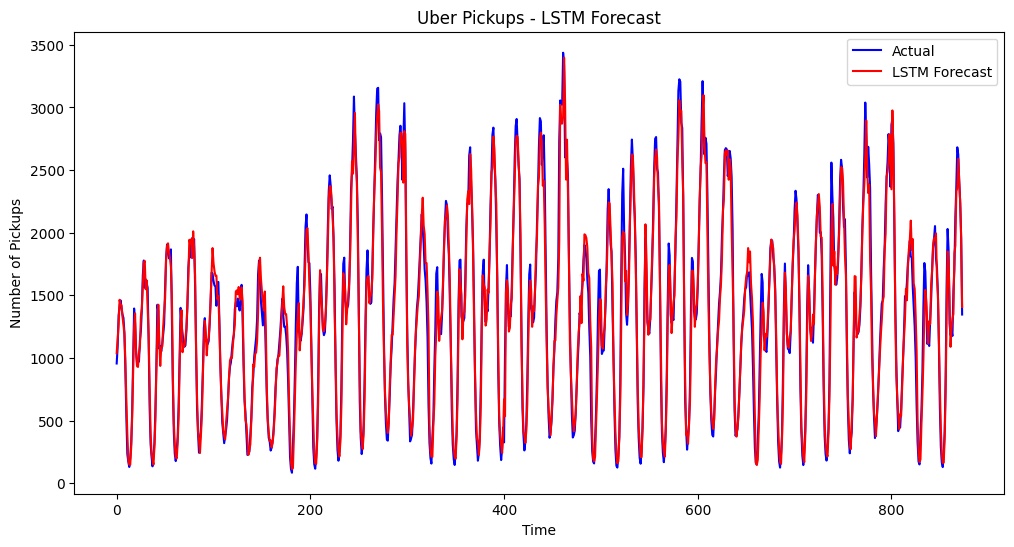

In [43]:
scaler = MinMaxScaler()
df_time_series["Scaled_Pickups"] = scaler.fit_transform(df_time_series["Pickups"].values.reshape(-1,1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(df_time_series["Scaled_Pickups"].values, seq_length)

split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual", color="blue")
plt.plot(y_pred_inv, label="LSTM Forecast", color="red")
plt.xlabel("Time")
plt.ylabel("Number of Pickups")
plt.title("Uber Pickups - LSTM Forecast")
plt.legend()
plt.show()

In [44]:
evaluate_forecast(y_test_inv, y_pred_inv, "LSTM")

LSTM Evaluation:
MAE: 110.26
MSE: 22269.19
RMSE: 149.23
MAPE: 11.60%



## 6. Clustering Modelling for Hotspot Detection

### 6.1 K Means Clustering

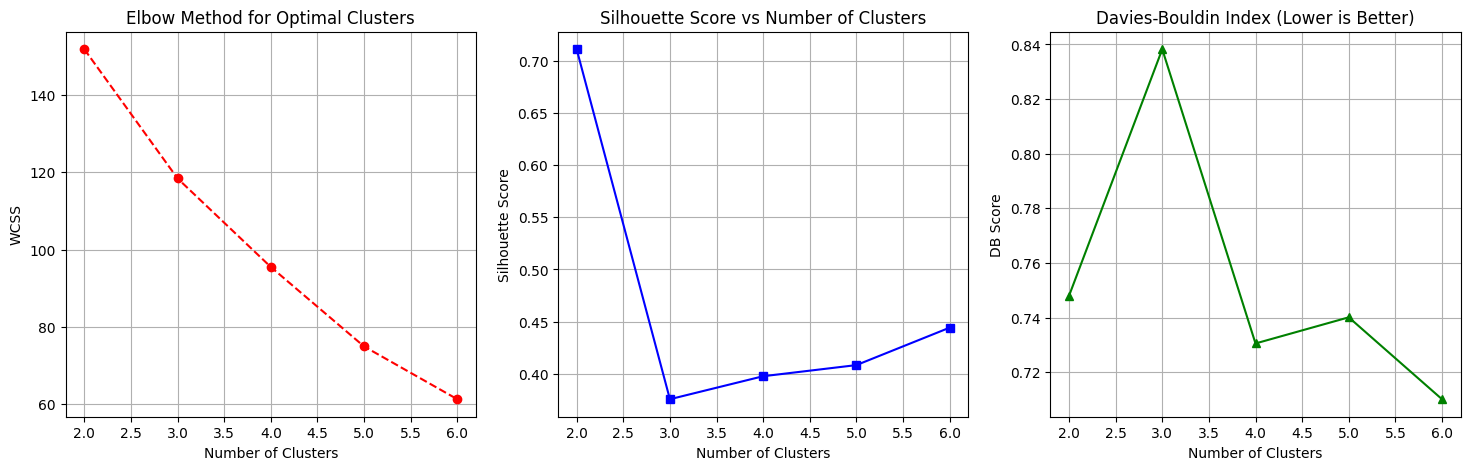

In [45]:
df_sampled = df[['Lat', 'Lon']].sample(50000, random_state=42)  # Smaller sample size to reduce computational requirement

# Lists to store evaluation metrics
wcss = []
silhouette_scores = []
db_scores = []
ch_scores = []

for i in range(2, 7):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_sampled)

    # Compute metrics
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_sampled, labels))
    db_scores.append(davies_bouldin_score(df_sampled, labels))
    ch_scores.append(calinski_harabasz_score(df_sampled, labels))

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# WCSS (Elbow Method)
ax[0].plot(range(2, 7), wcss, marker='o', linestyle='--', color='red')
ax[0].set_title("Elbow Method for Optimal Clusters")
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("WCSS")
ax[0].grid()

# Silhouette Score
ax[1].plot(range(2, 7), silhouette_scores, marker='s', linestyle='-', color='blue')
ax[1].set_title("Silhouette Score vs Number of Clusters")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid()

# Davies-Bouldin Score
ax[2].plot(range(2, 7), db_scores, marker='^', linestyle='-', color='green')
ax[2].set_title("Davies-Bouldin Index (Lower is Better)")
ax[2].set_xlabel("Number of Clusters")
ax[2].set_ylabel("DB Score")
ax[2].grid()

plt.show()

In [46]:
best_k = np.argmax(silhouette_scores) + 2 

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_sampled)

sil_score = silhouette_score(df_sampled, labels)
db_score = davies_bouldin_score(df_sampled, labels)
ch_score = calinski_harabasz_score(df_sampled, labels)

print(f"Optimized Evaluation for Best K ({best_k} Clusters):")
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Davies-Bouldin Index: {db_score:.2f}")
print(f"Calinski-Harabasz Index: {ch_score:.2f}")

Optimized Evaluation for Best K (2 Clusters):
Silhouette Score: 0.71
Davies-Bouldin Index: 0.75
Calinski-Harabasz Index: 30268.16


### 6.2 Density-Based Clustering (DBSCAN)

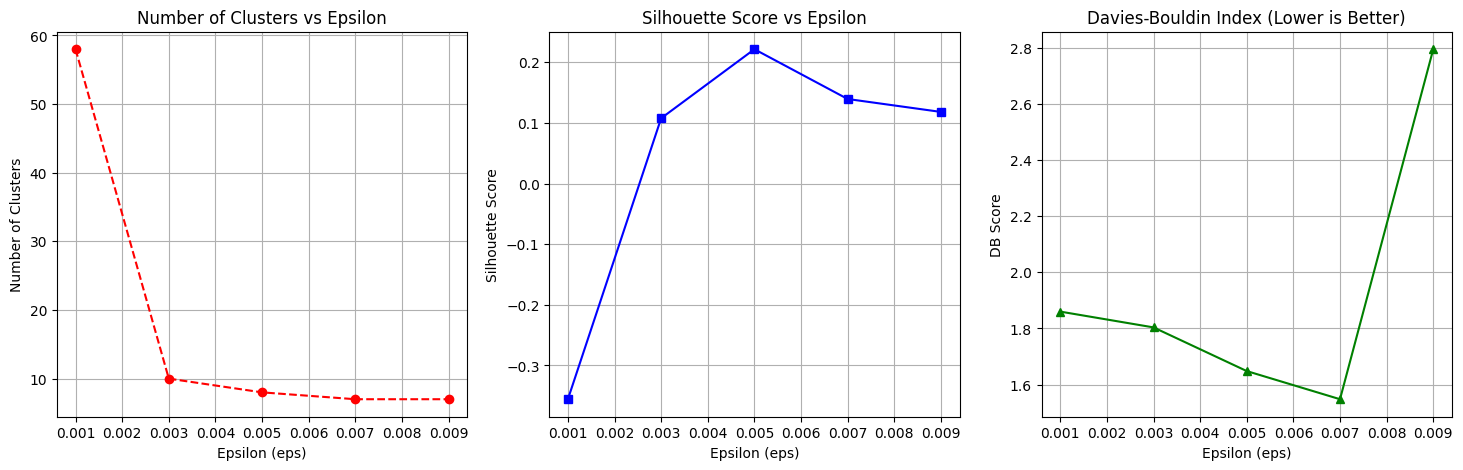

In [47]:
df_sampled = df[['Lat', 'Lon']].sample(10000, random_state=42)

eps_values = np.arange(0.001, 0.01, 0.002)
silhouette_scores = []
db_scores = []
num_clusters = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=20)
    labels = dbscan.fit_predict(df_sampled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)

    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(df_sampled, labels))
        db_scores.append(davies_bouldin_score(df_sampled, labels))
    else:
        silhouette_scores.append(np.nan)  # Avoids NaN errors
        db_scores.append(np.nan)

# Plot Evaluation Metrics
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Number of Clusters vs Epsilon
ax[0].plot(eps_values, num_clusters, marker='o', linestyle='--', color='red')
ax[0].set_title("Number of Clusters vs Epsilon")
ax[0].set_xlabel("Epsilon (eps)")
ax[0].set_ylabel("Number of Clusters")
ax[0].grid()

# Silhouette Score
ax[1].plot(eps_values, silhouette_scores, marker='s', linestyle='-', color='blue')
ax[1].set_title("Silhouette Score vs Epsilon")
ax[1].set_xlabel("Epsilon (eps)")
ax[1].set_ylabel("Silhouette Score")
ax[1].grid()

# Davies-Bouldin Score
ax[2].plot(eps_values, db_scores, marker='^', linestyle='-', color='green')
ax[2].set_title("Davies-Bouldin Index (Lower is Better)")
ax[2].set_xlabel("Epsilon (eps)")
ax[2].set_ylabel("DB Score")
ax[2].grid()

plt.show()

In [48]:
best_eps_idx = np.nanargmax(silhouette_scores)
best_eps = eps_values[best_eps_idx]

dbscan = DBSCAN(eps=best_eps, min_samples=20)
labels = dbscan.fit_predict(df_sampled)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters > 1:
    sil_score = silhouette_score(df_sampled, labels)
    db_score = davies_bouldin_score(df_sampled, labels)
else:
    sil_score = np.nan
    db_score = np.nan

print(f"Optimized Evaluation for DBSCAN (Epsilon = {best_eps:.4f}):")
print(f"Number of Clusters: {n_clusters}")
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Davies-Bouldin Index: {db_score:.2f}")

Optimized Evaluation for DBSCAN (Epsilon = 0.0050):
Number of Clusters: 8
Silhouette Score: 0.22
Davies-Bouldin Index: 1.65


## 7. Classification Model

In [49]:
df.head()

,Date/Time,Lat,Lon,Base,DateTime,Base Name,Year,Month,Day,Hour,Minute,DayOfWeek
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512,2014-05-01 00:02:00,Unter,2014,5,1,0,2,3
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512,2014-05-01 00:06:00,Unter,2014,5,1,0,6,3
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512,2014-05-01 00:15:00,Unter,2014,5,1,0,15,3
3,5/1/2014 0:17:00,40.7463,-74.0011,B02512,2014-05-01 00:17:00,Unter,2014,5,1,0,17,3
4,5/1/2014 0:17:00,40.7594,-73.9734,B02512,2014-05-01 00:17:00,Unter,2014,5,1,0,17,3


In [50]:
min_time = df["DateTime"].min()
max_time = df["DateTime"].max()

min_lat, max_lat = df["Lat"].min(), df["Lat"].max()
min_lon, max_lon = df["Lon"].min(), df["Lon"].max()

In [51]:
num_samples = len(df)

In [52]:
random_lats = np.random.uniform(min_lat, max_lat, num_samples)
random_lons = np.random.uniform(min_lon, max_lon, num_samples)

In [53]:
random_times = [min_time + timedelta(seconds=np.random.randint(0, int((max_time - min_time).total_seconds())))
                for _ in range(num_samples)]

In [54]:
negative_samples = pd.DataFrame({
    "Lat": random_lats,
    "Lon": random_lons,
    "DateTime": random_times,
    "pickup": 0
})

In [55]:
df["pickup"] = 1

In [56]:
positive_df = df[['Lat','Lon','DateTime','pickup']]

In [57]:
final_df = pd.concat([positive_df, negative_samples], ignore_index=True)

In [58]:
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [59]:
final_df.head()

,Lat,Lon,DateTime,pickup
0,40.648449,-72.435757,2014-08-21 20:19:36,0
1,40.715400,-73.963600,2014-06-14 19:49:00,1
2,40.776600,-73.952700,2014-05-14 19:39:00,1
3,40.691400,-73.944700,2014-08-13 07:06:00,1
4,42.073204,-72.482873,2014-08-09 18:05:32,0


In [60]:
X = final_df[['Lat','Lon']]
Y=final_df[['pickup']]

In [61]:
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.2,random_state=42)

In [62]:
def evaluate_classification(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc_roc:.2f}\n")

### 7.1 Logistic Regression

In [63]:
lr_model = LogisticRegression()
lr_model.fit(train_x, train_y)
y_pred = lr_model.predict(test_x)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [64]:
evaluate_classification(test_y,y_pred,"Logistic Regression")

Logistic Regression Evaluation:
Accuracy: 0.80
Precision: 0.72
Recall: 0.99
F1 Score: 0.83
AUC-ROC: 0.80



### 7.2 Random Forest

In [65]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(train_x, train_y)
y_pred = rf_model.predict(test_x)

<ipython-input-65-68ddba18fd22>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(train_x, train_y)


In [66]:
evaluate_classification(test_y,y_pred,"Logistic Regression")

Logistic Regression Evaluation:
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
AUC-ROC: 0.99



## 8. Conclusion

For the Time series segment, we shall use the LSTM model which has the lowest MAPE
For clustering segment, we shall use the K means model which has the highest Silhouette score among the two

In [67]:
model.save("lstm_uber_model.h5")
print("LSTM model saved as 'lstm_uber_model.h5'")

LSTM model saved as 'lstm_uber_model.h5'


In [68]:
joblib.dump(kmeans, 'kmeans_uber_model.pkl')
print("K-Means model saved as 'kmeans_uber_model.pkl'")

K-Means model saved as 'kmeans_uber_model.pkl'
